# Exercise: Pyomo.DoE

In this notebook, you will use Pyomo.DoE to compute the A- and D-optimal experiments from the TCLab. In our [previous notebook](../notebooks/doe_optimize.ipynb), we used the sine test as a starting point. In this notebook, we will use the step test as the starting point.

Recall, we can computing the next best experiment assuming we already completed one prior experiment. Thus it is important to confirm our optimal experiment design does not change if we change the prior experiment of optimization initial point.

In [1]:
import sys

# If running on Google Colab, install Pyomo and Ipopt via IDAES
on_colab = "google.colab" in sys.modules
if on_colab:
    !wget "https://raw.githubusercontent.com/dowlinglab/pyomo-doe/main/notebooks/tclab_pyomo.py"
else:
    import os

    if "exercise_solutions" in os.getcwd():
        # Add the "notebooks" folder to the path
        # This is needed for running the solutions from a separate folder
        # You only need this if you run locally
        sys.path.append('../notebooks')

# import TCLab model, simulation, and data analysis functions
from tclab_pyomo import (
    TCLabExperiment,
    create_model,
    extract_results,
    extract_plot_results,
    results_summary,
)

# set default number of states in the TCLab model
number_tclab_states = 2

## Load and explore experimental data (step test)

We will load the step test experimental data, similar to our previous notebooks.

In [2]:
import pandas as pd

if on_colab:
    file = "https://raw.githubusercontent.com/dowlinglab/pyomo-doe/main/data/tclab_step_test.csv"
else:
    file = '../data/tclab_step_test.csv'
df = pd.read_csv(file)
df.head()

,Time,T1,T2,Q1,Q2
0,0.00,22.84,22.52,50.0,0.0
1,1.01,22.84,22.52,50.0,0.0
2,2.01,22.84,22.52,50.0,0.0
3,3.00,22.84,22.52,50.0,0.0
4,4.00,22.84,22.20,50.0,0.0


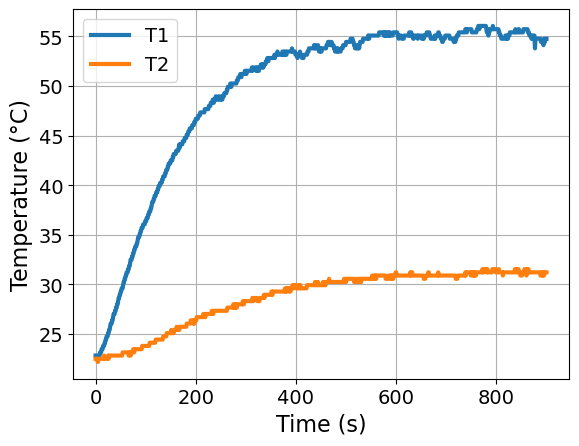

In [3]:
ax = df.plot(x='Time', y=['T1', 'T2'], xlabel='Time (s)', ylabel='Temperature (°C)')
ax.grid(True)

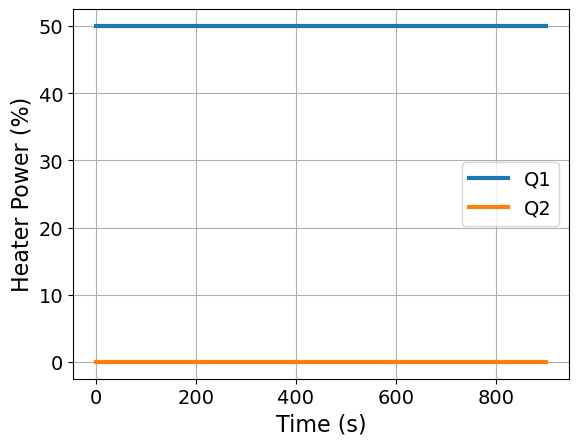

In [4]:
ax = df.plot(x='Time', y=['Q1', 'Q2'], xlabel='Time (s)', ylabel='Heater Power (%)')
ax.grid(True)

In [5]:
tc_data = TCLabExperiment(
    name="Sine Wave Test for Heater 1",
    time=df['Time'].values,
    T1=df['T1'].values,
    u1=df['Q1'].values,
    P1=200,
    TS1_data=None,
    T2=df['T2'].values,
    u2=df['Q2'].values,
    P2=200,
    TS2_data=None,
    Tamb=df['T1'].values[0],
)

## Analyze FIM with Pyomo.DoE at initial point (step test)

To get started, compute and analyze the FIM of the step test experiment.

In [6]:
# Load Pyomo.DoE functions
### BEGIN SOLUTION
from pyomo.contrib.doe import (
    ModelOptionLib,
    DesignOfExperiments,
    MeasurementVariables,
    DesignVariables,
)

from pyomo.environ import SolverFactory

### END SOLUTION

# Copied from previous notebook
theta_values = {
    'Ua': 0.05147278733764012,
    'Ub': 0.0005342082856927798,
    'inv_CpH': 0.14622879403418604,
    'inv_CpS': 99.99999754623846,
}

In [7]:
# Get time points for control decisions
### BEGIN SOLUTION
t_control = tc_data.time
### END SOLUTION

# Define the measurement variables
measurements = MeasurementVariables()
### BEGIN SOLUTION
measurements.add_variables(
    'Ts1', 
    indices={0: t_control}, 
    time_index_position=0)

### END SOLUTION
print(measurements.variable_names)

['Ts1[0.0]', 'Ts1[1.01]', 'Ts1[2.01]', 'Ts1[3.0]', 'Ts1[4.0]', 'Ts1[5.01]', 'Ts1[6.01]', 'Ts1[7.01]', 'Ts1[8.01]', 'Ts1[9.01]', 'Ts1[10.01]', 'Ts1[11.01]', 'Ts1[12.01]', 'Ts1[13.01]', 'Ts1[14.01]', 'Ts1[15.01]', 'Ts1[16.01]', 'Ts1[17.0]', 'Ts1[18.01]', 'Ts1[19.01]', 'Ts1[20.0]', 'Ts1[21.01]', 'Ts1[22.0]', 'Ts1[23.01]', 'Ts1[24.01]', 'Ts1[25.01]', 'Ts1[26.01]', 'Ts1[27.01]', 'Ts1[28.01]', 'Ts1[29.01]', 'Ts1[30.01]', 'Ts1[31.01]', 'Ts1[32.01]', 'Ts1[33.01]', 'Ts1[34.01]', 'Ts1[35.01]', 'Ts1[36.01]', 'Ts1[37.01]', 'Ts1[38.01]', 'Ts1[39.01]', 'Ts1[40.01]', 'Ts1[41.01]', 'Ts1[42.01]', 'Ts1[43.01]', 'Ts1[44.01]', 'Ts1[45.01]', 'Ts1[46.01]', 'Ts1[47.01]', 'Ts1[48.01]', 'Ts1[49.01]', 'Ts1[50.01]', 'Ts1[51.0]', 'Ts1[52.01]', 'Ts1[53.01]', 'Ts1[54.0]', 'Ts1[55.01]', 'Ts1[56.01]', 'Ts1[57.01]', 'Ts1[58.01]', 'Ts1[59.01]', 'Ts1[60.01]', 'Ts1[61.01]', 'Ts1[62.01]', 'Ts1[63.01]', 'Ts1[64.01]', 'Ts1[65.0]', 'Ts1[66.0]', 'Ts1[67.01]', 'Ts1[68.01]', 'Ts1[69.01]', 'Ts1[70.01]', 'Ts1[71.01]', 'Ts1[72.01]

In [8]:
# Define the design variables
decisions = DesignVariables()

### BEGIN SOLUTION
decisions.add_variables(
    'U1',
    indices={0: t_control},
    time_index_position=0,
    lower_bounds=0,
    upper_bounds=100,
    values=tc_data.u1,
)
### END SOLUTION

print(decisions.variable_names)

['U1[0.0]', 'U1[1.01]', 'U1[2.01]', 'U1[3.0]', 'U1[4.0]', 'U1[5.01]', 'U1[6.01]', 'U1[7.01]', 'U1[8.01]', 'U1[9.01]', 'U1[10.01]', 'U1[11.01]', 'U1[12.01]', 'U1[13.01]', 'U1[14.01]', 'U1[15.01]', 'U1[16.01]', 'U1[17.0]', 'U1[18.01]', 'U1[19.01]', 'U1[20.0]', 'U1[21.01]', 'U1[22.0]', 'U1[23.01]', 'U1[24.01]', 'U1[25.01]', 'U1[26.01]', 'U1[27.01]', 'U1[28.01]', 'U1[29.01]', 'U1[30.01]', 'U1[31.01]', 'U1[32.01]', 'U1[33.01]', 'U1[34.01]', 'U1[35.01]', 'U1[36.01]', 'U1[37.01]', 'U1[38.01]', 'U1[39.01]', 'U1[40.01]', 'U1[41.01]', 'U1[42.01]', 'U1[43.01]', 'U1[44.01]', 'U1[45.01]', 'U1[46.01]', 'U1[47.01]', 'U1[48.01]', 'U1[49.01]', 'U1[50.01]', 'U1[51.0]', 'U1[52.01]', 'U1[53.01]', 'U1[54.0]', 'U1[55.01]', 'U1[56.01]', 'U1[57.01]', 'U1[58.01]', 'U1[59.01]', 'U1[60.01]', 'U1[61.01]', 'U1[62.01]', 'U1[63.01]', 'U1[64.01]', 'U1[65.0]', 'U1[66.0]', 'U1[67.01]', 'U1[68.01]', 'U1[69.01]', 'U1[70.01]', 'U1[71.01]', 'U1[72.01]', 'U1[73.01]', 'U1[74.0]', 'U1[75.01]', 'U1[76.01]', 'U1[77.01]', 'U1[78

In [9]:
# Define create_model function for Pyomo.DoE


### BEGIN SOLUTION
def create_model_doe(theta=theta_values):
    return create_model(
        data=tc_data,
        mode='doe',
        theta=theta,
        integrate_to_initialize=True,
        number_of_states=number_tclab_states,
    )


### END SOLUTION

In [10]:
# Create doe_object using DesignOfExperiments

### BEGIN SOLUTION
doe_object1 = DesignOfExperiments(
    theta_values,  # dictionary of parameters
    decisions,  # design variable
    measurements,  # measurement variable
    create_model_doe,  # model
    solver=SolverFactory('ipopt'),
)
### END SOLUTION

# Compute and print the FIM at this point
### BEGIN SOLUTION
result = doe_object1.compute_FIM(mode='sequential_finite', formula='central')
result.result_analysis()
### END SOLUTION

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

In [11]:
# Call our custom function to summarize the results
# and compute the eigendecomposition of the FIM

results_summary(result)

======Results Summary======
Four design criteria log10() value:
A-optimality: 9.582591203781318
D-optimality: -inf
E-optimality: nan
Modified E-optimality: nan

FIM:
 [[ 1.88711723e+08 -1.92132341e+08 -8.36680971e+06 -1.04546465e+03]
 [-1.92132341e+08  3.63446492e+09  6.13974556e+07  1.95353824e+04]
 [-8.36680971e+06  6.13974556e+07  1.46900265e+06  3.31088338e+02]
 [-1.04546465e+03  1.95353824e+04  3.31088338e+02  1.05006073e-01]]

eigenvalues:
 [ 3.64619173e+09  1.78169287e+08  2.84629140e+05 -2.36680716e-18]

eigenvectors:
 [[ 5.55173608e-02 -9.98044866e-01  2.87100552e-02 -1.06758213e-13]
 [-9.98313930e-01 -5.59743978e-02 -1.53676369e-02 -5.33299016e-06]
 [-1.69446191e-02  2.78084774e-02  9.99469644e-01 -2.48897590e-06]
 [-5.36617311e-06 -2.29296389e-07  2.40570040e-06  1.00000000e+00]]


/Users/adowling/Teaching/pyomo-doe/exercise_solutions/../notebooks/tclab_pyomo.py:790: RuntimeWarning: divide by zero encountered in log10
  print("D-optimality:", np.log10(result.det))
/Users/adowling/Teaching/pyomo-doe/exercise_solutions/../notebooks/tclab_pyomo.py:791: RuntimeWarning: invalid value encountered in log10
  print("E-optimality:", np.log10(result.min_eig))
/Users/adowling/Teaching/pyomo-doe/exercise_solutions/../notebooks/tclab_pyomo.py:792: RuntimeWarning: invalid value encountered in log10
  print("Modified E-optimality:", np.log10(result.cond))


**Discussion:** How does this FIM compare to the sine test experiment we [previously analyzed](../notebooks/doe_exploratory_analysis.ipynb)?

## Optimize the next experiment (A-optimality)

Now we are ready to compute the A-optimal next best experiment. Why are we starting with A-optimality? It runs faster so it is better for debugging syntax.

In [12]:
# Extract the prior FIM and Jacobian information from the previous
# result to use for initialization.
### BEGIN SOLUTION
prior = result.FIM.copy()
jac_for_initialization = result.jaco_information.copy()
### END SOLUTION

# Set Ipopt options
solver = SolverFactory('ipopt')
# solver.options['bound_push'] = 1E-10
solver.options['halt_on_ampl_error'] = 'yes'
# solver.options['tol'] = 1E-5
# solver.options['acceptable_tol'] = 1E-4
# solver.options['max_iter'] = 100
solver.options['linear_solver'] = 'ma57'

# Create a new DoE object
### BEGIN SOLUTION
doe_object3 = DesignOfExperiments(
    theta_values,  # dictionary of parameters
    decisions,  # design variable
    measurements,  # measurement variable
    create_model_doe,  # model
    solver=solver,
    prior_FIM=prior,  # use previous experiment as prior
)
### END SOLUTION

# Solve the DoE problem
### BEGIN SOLUTION
square_result3, optimize_result3 = doe_object3.stochastic_program(
    if_optimize=True,  # optimize
    if_Cholesky=False,  # use Cholesky decomposition
    scale_nominal_param_value=True,  # scale model parameter value
    objective_option="trace",  # objective option (need to debug/improve initialization)
    jac_initial=jac_for_initialization,  # initialize Jacobian with prior solution
    step=0.01,  # step size
)
### END SOLUTION

Ipopt 3.13.2: halt_on_ampl_error=yes
linear_solver=ma57


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale s

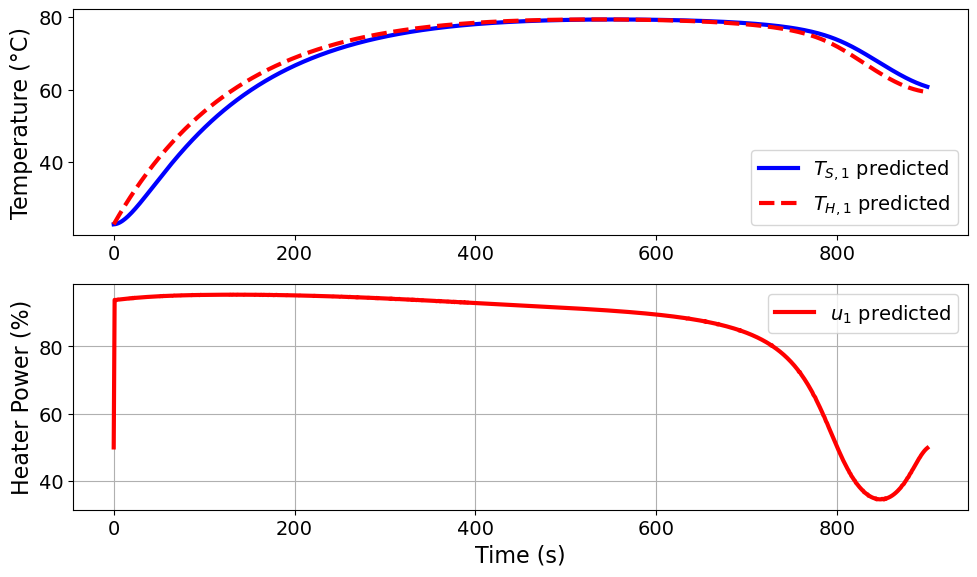

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
 


In [13]:
# Extract and plot the results using our custom function
### BEGIN SOLUTION
aopt_pyomo_doe_results = extract_plot_results(None, optimize_result3.model)
### END SOLUTION

In [14]:
# Compute the FIM at the optimal solution
### BEGIN SOLUTION
optimize_result3.result_analysis()
results_summary(optimize_result3)
### END SOLUTION

======Results Summary======
Four design criteria log10() value:
A-optimality: 9.582796323292156
D-optimality: 26.95067193479609
E-optimality: 3.537264228287819
Modified E-optimality: 6.024576525337041

FIM:
 [[ 1.90391979e+08 -1.92132808e+08 -8.52348771e+06 -1.77840673e+03]
 [-1.92132808e+08  3.63446924e+09  6.14164214e+07  2.38834153e+04]
 [-8.52348771e+06  6.14164214e+07  1.58687698e+06  1.94652290e+04]
 [-1.77840673e+03  2.38834153e+04  1.94652290e+04  4.37330692e+03]]

eigenvalues:
 [3.64620224e+09 1.79851735e+08 3.95050233e+05 3.44559500e+03]

eigenvectors:
 [[ 5.55450151e-02  9.98025494e-01  2.92889855e-02 -1.42125503e-03]
 [-9.98312254e-01  5.60117031e-02 -1.53227001e-02  7.40265391e-04]
 [-1.69527364e-02 -2.84218653e-02  9.98267898e-01 -4.86416176e-02]
 [-6.65676344e-06 -5.50679533e-06  4.86680064e-02  9.98815010e-01]]


**Discussion:** How do these compare to our [previous A-optimal results](../notebooks/doe_optimize.ipynb) considering the sine test as the prior experiment?

## Optimize the next experiment (D-optimality)

Finally, we are ready to solve the D-optimality problem. This may take 2 minutes to run.

In [15]:
# Create a new DoE object
### BEGIN SOLUTION
doe_object2 = DesignOfExperiments(
    theta_values,  # dictionary of parameters
    decisions,  # design variable
    measurements,  # measurement variable
    create_model_doe,  # model
    solver=solver,
    prior_FIM=prior,  # use previous experiment as prior
)
### END SOLUTION

# Solve the DoE problem
### BEGIN SOLUTION
square_result2, optimize_result2 = doe_object2.stochastic_program(
    if_optimize=True,  # optimize
    if_Cholesky=True,  # use Cholesky decomposition
    scale_nominal_param_value=True,  # scale model parameter value
    objective_option="det",  # objective option (need to debug/improve initialization)
    jac_initial=jac_for_initialization,  # initialize Jacobian with prior solution
    step=0.01,  # step size
)
### END SOLUTION

Ipopt 3.13.2: halt_on_ampl_error=yes
linear_solver=ma57


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale s

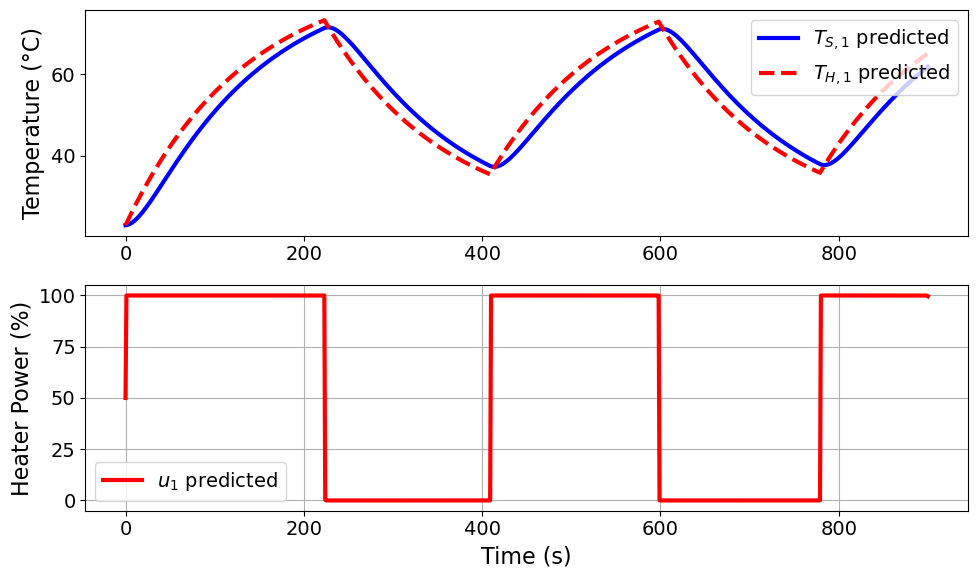

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
 


In [16]:
# Extract and plot the results using our custom function
### BEGIN SOLUTION
dopt_pyomo_doe_results = extract_plot_results(None, optimize_result2.model)
### END SOLUTION

In [17]:
# Compute the FIM at the optimal solution
### BEGIN SOLUTION
optimize_result2.result_analysis()
results_summary(optimize_result2)
### END SOLUTION

======Results Summary======
Four design criteria log10() value:
A-optimality: 9.582686431991858
D-optimality: 27.421333643942017
E-optimality: 3.9835045326404006
Modified E-optimality: 5.578336650278937

FIM:
 [[ 1.89390215e+08 -1.92128266e+08 -8.42095957e+06  2.93057215e+03]
 [-1.92128266e+08  3.63447636e+09  6.14249883e+07  3.10048527e+04]
 [-8.42095957e+06  6.14249883e+07  1.60629717e+06  2.80506246e+04]
 [ 2.93057215e+03  3.10048527e+04  2.80506246e+04  1.14972347e+04]]

eigenvalues:
 [3.64620584e+09 1.78848654e+08 4.20244707e+05 9.62730061e+03]

eigenvectors:
 [[ 5.55271027e-02  9.98038358e-01  2.88493756e-02 -1.97230315e-03]
 [-9.98313236e-01  5.59875664e-02 -1.53303741e-02  1.02700975e-03]
 [-1.69535692e-02 -2.80147733e-02  9.97185837e-01 -6.74400151e-02]
 [-8.57479987e-06  2.16670733e-05  6.74766613e-02  9.97720853e-01]]


**Discussion:** How do these results compare to [our previous analysis](../notebooks/doe_exercise.ipynb)?